In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from torchvision.models import vit_b_16
from torchvision import transforms, models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
import cv2
import numpy as np
import os
import timm

%run helpFunction.ipynb

In [ ]:
def apply_canny(image, image_size):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    tight = cv2.Canny(blurred, 140, 160)
    tight = cv2.resize(tight, image_size)
    tight = np.expand_dims(tight, axis=-1)
    return tight

def apply_morphology(image, target_size):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 190, 210, cv2.THRESH_BINARY)
    kernel = np.ones((5,5), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    image = cv2.resize(eroded, target_size)
    image = np.expand_dims(image, axis=-1)
    return image

def black_and_white(image, target_size):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, target_size)
    image = np.expand_dims(image, axis=-1)
    return image


In [ ]:
class VerkehrsschilderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for label, subfolder in enumerate(['y', 'n']):
            folder_path = os.path.join(self.root_dir, subfolder)
            for image_name in os.listdir(folder_path):
                self.images.append(os.path.join(folder_path, image_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path)

        canny_image = apply_canny(image, (224, 224))
        morphology_image = apply_morphology(image, (224, 224))
        bw_image = black_and_white(image, (224, 224))

        combined_image = np.concatenate((canny_image, morphology_image, bw_image), axis=-1)

        combined_image = Image.fromarray(np.uint8(combined_image))
        if self.transform:
            combined_image = self.transform(combined_image)

        return combined_image, label


transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomGrayscale(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset erstellen
dataset = VerkehrsschilderDataset('data', transform=transform)

total_count = len(dataset)
train_count = int(0.7 * total_count)
valid_count = int(0.15 * total_count)
test_count = total_count - train_count - valid_count  # Adjust to ensure all data is used

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_count, valid_count, test_count])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = ['Wartelinie', 'keine Wartelinie']

In [ ]:
print(total_count)
VerkehrsschilderDataset.__getitem__(dataset, 900)

In [ ]:
def show_image(image, label):
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.title('Label: ' + ('Wartelinie' if label == 0 else 'keine Wartelinie'))
    plt.show()

show_image(VerkehrsschilderDataset.__getitem__(dataset, 600)[0], VerkehrsschilderDataset.__getitem__(dataset, 600)[1])

In [ ]:
class HybridTransformerModel(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(HybridTransformerModel, self).__init__()
        
        # Vision Transformer
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit.head = nn.Identity()
        self.num_features_vit = self.vit.embed_dim

        # DeiT
        self.deit = timm.create_model('deit_base_patch16_224', pretrained=True)
        self.deit.head = nn.Identity()
        self.num_features_deit = self.deit.embed_dim

        # Combine the features
        self.fc1 = nn.Linear(self.num_features_vit + self.num_features_deit, 768)
        self.bn1 = nn.BatchNorm1d(768)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(768, num_classes)

    def forward(self, x):
        vit_features = self.vit(x)
        deit_features = self.deit(x)
        
        combined_features = torch.cat((vit_features, deit_features), dim=1)
        
        x = self.fc1(combined_features)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = HybridTransformerModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Verlustfunktion und Optimierer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc2.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def validate_model(model, criterion, valid_loader):
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    validation_loss = validation_loss / len(valid_loader)
    validation_accuracy = 100 * correct / total
    
    print(f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%')
    return validation_loss, validation_accuracy


In [ ]:
def train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=5, patience=5):
    model.train()
    best_val_loss = float('inf')
    patience_counter = 0
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%')
        
        val_loss, val_accuracy = validate_model(model, criterion, valid_loader)

        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    return history

In [ ]:
def evaluate_model(model, criterion, test_loader, class_names):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())
    
    test_loss /= len(test_loader)
    accuracy = 100 * correct / total

    prediction_csv(all_labels, all_preds, 'Hybridmodel - ViT & DeiT')

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - Hybridmodel - ViT & DeiT')
    plt.show()

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')


Epoch 1/40, Training Loss: 0.6545, Training Accuracy: 61.63%
Validation Loss: 0.5456, Validation Accuracy: 73.85%
Epoch 2/40, Training Loss: 0.5408, Training Accuracy: 74.88%
Validation Loss: 0.4655, Validation Accuracy: 78.90%
Epoch 3/40, Training Loss: 0.4953, Training Accuracy: 75.56%
Validation Loss: 0.4761, Validation Accuracy: 78.44%
No improvement in validation loss for 1 epochs.
Epoch 4/40, Training Loss: 0.4623, Training Accuracy: 78.80%
Validation Loss: 0.4943, Validation Accuracy: 77.52%
No improvement in validation loss for 2 epochs.
Epoch 5/40, Training Loss: 0.4512, Training Accuracy: 79.88%
Validation Loss: 0.4492, Validation Accuracy: 80.28%
Epoch 6/40, Training Loss: 0.4638, Training Accuracy: 78.02%
Validation Loss: 0.4548, Validation Accuracy: 80.73%
No improvement in validation loss for 1 epochs.
Epoch 7/40, Training Loss: 0.4181, Training Accuracy: 80.57%
Validation Loss: 0.4380, Validation Accuracy: 80.28%
Epoch 8/40, Training Loss: 0.4294, Training Accuracy: 80.3

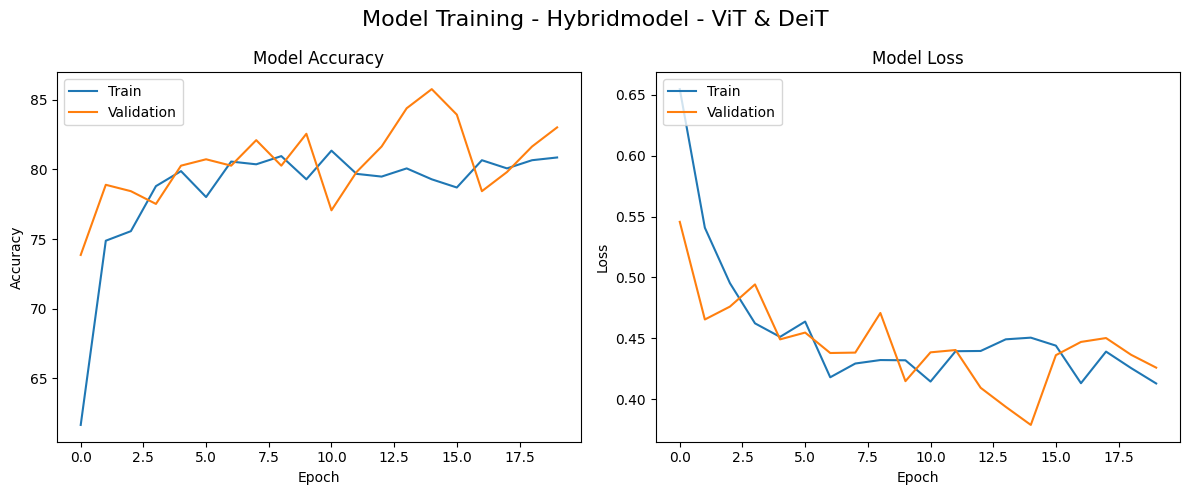

In [11]:
history = train_model(model, criterion, optimizer, scheduler, train_loader, valid_loader, num_epochs=40)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.suptitle('Model Training - Hybridmodel - ViT & DeiT', fontsize=16)
plt.tight_layout()
plt.show()

              precision    recall  f1-score     support
0              0.800000  0.808081  0.804020   99.000000
1              0.840336  0.833333  0.836820  120.000000
accuracy       0.821918  0.821918  0.821918    0.821918
macro avg      0.820168  0.820707  0.820420  219.000000
weighted avg   0.822102  0.821918  0.821993  219.000000
82.1917808219178
                     Modell Accuracy Precision Recall F1-Score  \
0  Hybridmodel - ViT & DeiT      82%       82%    82%      82%   

                        Date  
0 2024-05-26 02:57:04.507642  


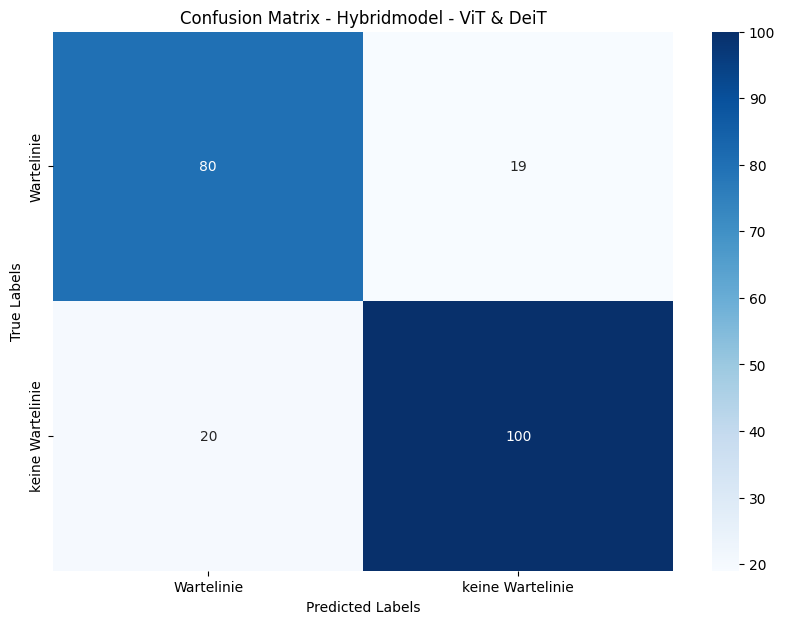

Test Loss: 0.4368, Test Accuracy: 82.19%


In [12]:
evaluate_model(model, criterion, test_loader, class_names)